### Import Modules

Downloading some modules into the session

In [1]:
!pip install lxml_html_clean
!pip install newspaper3k

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=b4a098a5d87fe251f07126c0119aa4f18a370425f4eef51f1913db539808c15c
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=ed2c0a4780b8832ac8bc3d26c865c68c7cc5fc85c14f85d51ee036b3860f43db
  Stored in directory: /root/.cache/pip/wheels/97/02/e7/a1ff1760e12bdbaab0ac824fae5c1bc

In [2]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import pipeline
from scipy.special import softmax
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from newspaper import Config, Article
from bs4 import BeautifulSoup
import requests

### Input Preprocessing functions

Choose any one of the input methods to execute

i) Fetches data by reading a file(upload the file into session)

In [3]:
def read_data(filename):
    sentences = []

    # Open the file in read mode
    with open(filename, 'r') as file:
        # Read each line in the file
        for line in file:
            # Strip leading/trailing whitespaces
            line = line.strip()
            # If the line is not empty, split it into sentences and add them to the list
            if line:
                # Split the line into sentences based on common delimiters like '.', '!', '?'
                line_sentences = [s.strip() for s in line.split('.') if s.strip()]
                # Extend the list of sentences
                sentences.extend(line_sentences)

    return sentences

ii) Fetches data from NEWS websites through scraping

In [4]:
def newsFetch():
    # Define the newsFetch function
    def fetch_latest_news_titles(url, printed_titles):
        # Set up configuration for the newspaper library
        config = Config()
        config.fetch_images = False
        config.memoize_articles = False

        # Fetch the HTML content of the website
        response = requests.get(url)
        soup = BeautifulSoup(response.content, 'html.parser')

        # Extract links to individual articles
        article_links = []
        for link in soup.find_all('a', href=True):
            href = link['href']
            if href.startswith('http'):
                article_links.append(href)

        # Fetch and convert the titles of the latest news articles into the specified format
        formatted_titles = []
        for article_link in article_links:
            try:
                article = Article(article_link, config=config)
                article.download()
                article.parse()
                # Check if the title has more than 3 words and is not already printed
                title_words = article.title.split()
                if len(title_words) > 3 and article.title not in printed_titles:
                    formatted_titles.append(article.title)
                    printed_titles.add(article.title)  # Add the title to printed_titles set
            except Exception as e:
                print(f"Error fetching news from {article_link}: {e}\n")

        return formatted_titles

    # List of financial news websites
    financial_news_sites = [
        "https://www.cnbc.com/finance/"
        # Add more financial news websites here as needed
    ]

    printed_titles = set()  # Set to store printed titles

    # Fetch and print the titles of the latest news from each website
    data = []
    for site in financial_news_sites:
        data.extend(fetch_latest_news_titles(site, printed_titles))

    # Return the final list of formatted titles
    return data

### Input Data
i) Fetch news data by scraping CNBC website headlines. <br>
ii) Fetch data from uploaded files.

In [5]:
sentences=newsFetch()

Error fetching news from https://www.twitter.com/cnbc/: Article `download()` failed with 400 Client Error: Bad Request for url: https://twitter.com/cnbc/ on URL https://www.twitter.com/cnbc/

Error fetching news from https://help.cnbc.com/: Article `download()` failed with 403 Client Error: Forbidden for url: https://cnbc.zendesk.com/hc/en-us/ on URL https://help.cnbc.com/

Error fetching news from https://help.cnbc.com/contact/: Article `download()` failed with 403 Client Error: Forbidden for url: https://cnbc.zendesk.com/hc/en-us/requests/new?ticket_form_id=360000260093 on URL https://help.cnbc.com/contact/



In [ ]:
filename = '/content/data.txt'
sentences = read_data(filename)

### Viewing Sentences Fetched

In [6]:
sentences

['Jack Ma is praising Alibaba. Wall Street is more cautious',
 "'Buffett really was not a great stock picker': Financial researcher Larry Swedroe on how investors can emulate the billionaire investor",
 'Stocks making the biggest moves midday: Globe Life, JPMorgan, Zoetis, Wells Fargo and more',
 "90% of qualifying electric-vehicle buyers opt for $7,500 'new clean vehicle' tax credit as upfront payment, Treasury says",
 "Cathie Wood takes a stake in OpenAI, saying it's at the forefront of a 'Cambrian explosion' in AI",
 'Stocks making the biggest moves before the bell: JPMorgan, BlackRock, Globe Life and more',
 'Citigroup tops estimates for first-quarter revenue on better-than-expected Wall Street results',
 'Wells Fargo earnings top estimates even as lower interest income cuts into profits',
 'JPMorgan Chase shares drop after bank gives disappointing guidance on 2024 interest income',
 'Physical gold offers more protection than mining stocks, says State Street’s George Milling-Stanle

### Making the Model

Fetching BERT model tokeniser and weights for financial entity recognition.

In [7]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/59.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/433M [00:00<?, ?B/s]

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
nlp = pipeline("ner", model=model, tokenizer=tokenizer)

In [9]:
def extract_organization_examples(examples):
    organization_examples_dict = {}

    for example in examples:
        ner_results = nlp(example)
        organization_name = ""
        for result in ner_results:
            if result['entity'] == 'B-ORG':
                organization_name += result['word']
            elif result['entity'] == 'I-ORG':
                organization_name += result['word'].replace("##", "")

        if organization_name:
            if organization_name not in organization_examples_dict:
                organization_examples_dict[organization_name] = [example]
            else:
                organization_examples_dict[organization_name].append(example)

    return organization_examples_dict


Displaying organization with their sentences for further sentiment analysis.

In [10]:
organization_examples = extract_organization_examples(sentences)
print(organization_examples)

{'Alibaba': ['Jack Ma is praising Alibaba. Wall Street is more cautious'], 'GlobeLifeJPMorganZoetisWellsFargo': ['Stocks making the biggest moves midday: Globe Life, JPMorgan, Zoetis, Wells Fargo and more'], 'Treasury': ["90% of qualifying electric-vehicle buyers opt for $7,500 'new clean vehicle' tax credit as upfront payment, Treasury says"], 'OpenAIAI': ["Cathie Wood takes a stake in OpenAI, saying it's at the forefront of a 'Cambrian explosion' in AI"], 'JPMorganBlackRockGlobeLife': ['Stocks making the biggest moves before the bell: JPMorgan, BlackRock, Globe Life and more'], 'Citigroup': ['Citigroup tops estimates for first-quarter revenue on better-than-expected Wall Street results'], 'WellsFargo': ['Wells Fargo earnings top estimates even as lower interest income cuts into profits'], 'JPMorganChase': ['JPMorgan Chase shares drop after bank gives disappointing guidance on 2024 interest income'], 'GeorgeMillingStanley': ['Physical gold offers more protection than mining stocks, sa

Fetching Financial BERT for sentiment analysis on financial entities.

In [11]:
tokenizer = AutoTokenizer.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")
model = AutoModelForSequenceClassification.from_pretrained("ahmedrachid/FinancialBERT-Sentiment-Analysis")

tokenizer_config.json:   0%|          | 0.00/369 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/464k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/789 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

In [12]:
def get_max_indices(sentences_dict, model, tokenizer):
    max_indices = {}
    for key, sentences in sentences_dict.items():
        scores_list = []
        for sentence in sentences:
            encoded_text = tokenizer(sentence, return_tensors='pt')
            output = model(**encoded_text)
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            scores_list.append(np.argmax(scores))
        max_indices[key] = scores_list
    return max_indices

Sentiment data for each financial entity.<br>
negative sentiment => 0<br>
neutral sentiment => 1<br>
positive sentiment => 2<br>

In [13]:
data = get_max_indices(organization_examples, model, tokenizer)
data

{'Alibaba': [2],
 'GlobeLifeJPMorganZoetisWellsFargo': [1],
 'Treasury': [1],
 'OpenAIAI': [1],
 'JPMorganBlackRockGlobeLife': [1],
 'Citigroup': [2],
 'WellsFargo': [2],
 'JPMorganChase': [0],
 'GeorgeMillingStanley': [2],
 'CarMaxNikeParamountFastenal': [1],
 'NikeCarMaxRobinhoodAlpineImmuneSciences': [1],
 'GoldmanSachs': [1, 1],
 'UBS': [0],
 'Fed': [0, 2],
 'CavaNvidiaDeckersBlockTaiwanSemiconductor': [1],
 'AlbemarleDeckersOutdoorGoodRxNvidia': [1],
 'NewYorkCommunityBank': [1],
 'mura': [1],
 'WellsFargoS&P': [2],
 'BoeingNorfolkSouthernNvidia': [1],
 'AmericanEagleOutfittersAllyFinancialMolsonCoorsBeverage': [1],
 'GEVernovaSoFiTechnologiesTesla': [1],
 "TeslaTake-TwoInteractiveBJ'sWholesaleBoeing": [1],
 'Ripple': [2],
 'Tesla': [1],
 'CNBC': [1],
 'C-Suite': [1],
 'StreamTVandMoviesOnlineWatchLiveNewsandSports': [1],
 'CNBCInsights': [1]}

Calculating a sentiment score for each financial data. Add 1 to the score for each positive sentiment and subtract 1 for each negative sentiment. If neutral don't add any thing.

In [14]:
sentiment_scores = {}

for company, sentiments in data.items():
    score = 0
    for sentiment in sentiments:
        if sentiment == 2:
            score += 1
        elif sentiment == 0:
            score -= 1
    sentiment_scores[company] = score

# Extracting x and y data for plotting
companies = list(sentiment_scores.keys())
scores = list(sentiment_scores.values())

### Visualization Dashboard<br>
This code defines two dictionaries positive_sentiments and negative_sentiments based on sentiment scores, sorts them, and then creates visualizations using bar charts and pie charts.

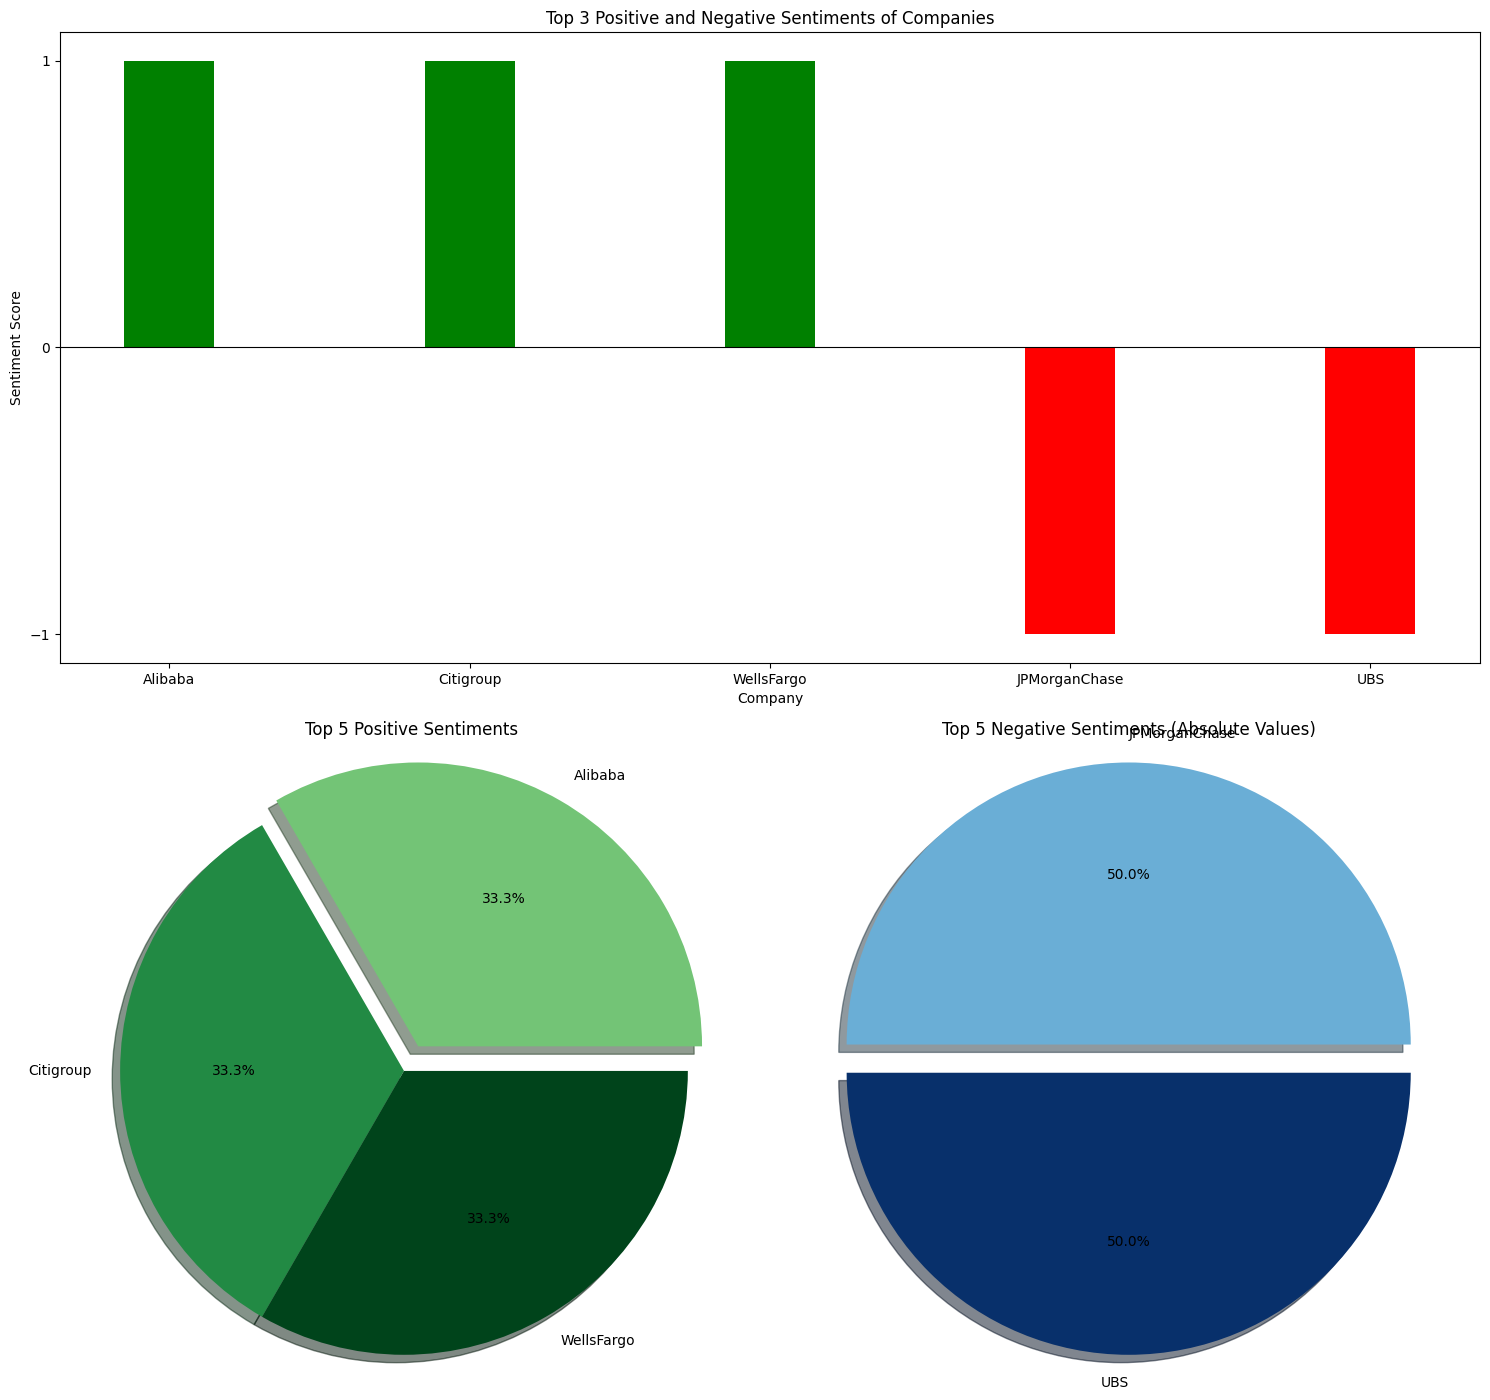

In [15]:
positive_sentiments = {company: score for company, score in sentiment_scores.items() if score > 0}
negative_sentiments = {company: abs(score) for company, score in sentiment_scores.items() if score < 0}

# Sorting the sentiment scores
sorted_positive_sentiments = dict(sorted(positive_sentiments.items(), key=lambda item: item[1], reverse=True)[:3])
sorted_negative_sentiments = dict(sorted(negative_sentiments.items(), key=lambda item: abs(item[1]), reverse=True)[:3])

# Plotting the bar chart
plt.figure(figsize=(15, 14))

plt.subplot(2, 1, 1)
plt.bar(sorted_positive_sentiments.keys(), sorted_positive_sentiments.values(), color='green', width=0.3)
plt.bar(sorted_negative_sentiments.keys(), [-score for score in sorted_negative_sentiments.values()], color='red', width=0.3)  # Invert y-coordinate
plt.xlabel('Company')
plt.ylabel('Sentiment Score')
plt.title('Top 3 Positive and Negative Sentiments of Companies')
plt.axhline(color='black', linewidth=0.8)  # Adding a horizontal line at y=0

# Set y-axis ticks and labels to negative values for negative sentiment
plt.yticks(np.arange(-max(sorted_negative_sentiments.values()), max(sorted_positive_sentiments.values())+1, 1))

# Colors for positive sentiment pie chart
if sorted_positive_sentiments:
    positive_colors = cm.Greens(np.linspace(0.5, 1, len(sorted_positive_sentiments)))
else:
    positive_colors = None

# Pie chart for positive sentiments
plt.subplot(2, 2, 3)
if sorted_positive_sentiments:
    explode_pos = [0.1 if i == 0 else 0 for i in range(len(sorted_positive_sentiments))]
    plt.pie(sorted_positive_sentiments.values(), labels=sorted_positive_sentiments.keys(), autopct='%1.1f%%', explode=explode_pos, colors=positive_colors, shadow=True)
    plt.title('Top 5 Positive Sentiments')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
else:
    plt.text(0.5, 0.5, 'No positive sentiments', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')  # Turn off axis

# Colors for negative sentiment pie chart
if sorted_negative_sentiments:
    negative_colors = cm.Blues(np.linspace(0.5, 1, len(sorted_negative_sentiments)))
else:
    negative_colors = None

# Pie chart for negative sentiments
plt.subplot(2, 2, 4)
if sorted_negative_sentiments:
    explode_neg = [0.1 if i == 0 else 0 for i in range(len(sorted_negative_sentiments))]
    plt.pie(sorted_negative_sentiments.values(), labels=sorted_negative_sentiments.keys(), autopct='%1.1f%%', explode=explode_neg, colors=negative_colors, shadow=True)
    plt.title('Top 5 Negative Sentiments (Absolute Values)')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
else:
    plt.text(0.5, 0.5, 'No negative sentiments', horizontalalignment='center', verticalalignment='center', fontsize=12)
    plt.axis('off')  # Turn off axis

plt.tight_layout()
plt.show()